# Detección de Clickbait: Análisis Comparativo de Modelos

## Introducción

Este notebook presenta un análisis exhaustivo de diferentes enfoques para la detección de clickbait en titulares de noticias. El objetivo es comparar modelos clásicos de machine learning con modelos basados en embeddings pre-entrenados (GloVe y BERT) para determinar qué enfoque es más efectivo y eficiente para esta tarea.

### Objetivos

1. **Establecer una línea base** con modelos clásicos (BoW y TF-IDF)
2. **Evaluar embeddings pre-entrenados** (GloVe y BERT)
3. **Analizar patrones lingüísticos** que caracterizan el clickbait
4. **Comparar rendimiento y complejidad** de cada enfoque

### Hipótesis

Aunque los modelos de lenguaje grandes (LLMs) como BERT pueden capturar representaciones semánticas más ricas, **hipotetizamos que para la detección de clickbait, modelos más simples y eficientes pueden ser suficientes**, ya que esta tarea se basa principalmente en patrones superficiales y características léxicas específicas.


## 1. Configuración e Imports

En esta sección importamos todas las librerías necesarias y configuramos el entorno para los experimentos.


In [ ]:
# Imports generales
import re
import os
import urllib.error
import urllib.request
import zipfile
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import bigrams, pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from tqdm import tqdm

# Configuración de dependencias opcionales
try:
    import gensim
    from gensim.models import KeyedVectors
    from gensim.scripts.glove2word2vec import glove2word2vec
    GENSIM_AVAILABLE = True
except ImportError:
    GENSIM_AVAILABLE = False
    print("Gensim no disponible. Instalar con: pip install gensim")

try:
    from transformers import BertTokenizer, BertModel
    import torch
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("Transformers no disponible. Instalar con: pip install transformers torch")

# Descargar recursos NLTK
nltk.download("stopwords", raise_on_error=True)
nltk.download("wordnet", raise_on_error=True)
nltk.download("omw-1.4", raise_on_error=True)
nltk.download("averaged_perceptron_tagger_eng", raise_on_error=True)
nltk.download("punkt", raise_on_error=True)

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)


[nltk_data] Downloading package stopwords to /home/ts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ts/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ts/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/ts/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/ts/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Carga de Datos y Preprocesamiento

### 2.1 Carga del Dataset

Cargamos el dataset de clickbait que contiene titulares de noticias etiquetados como clickbait (1) o no clickbait (0).


In [ ]:
# Cargar dataset
df = pd.read_csv("assets/clickbait_data.csv")
df = df.dropna(subset=["headline", "clickbait"])

print("Shape:", df.shape)
print("\nPrimeras filas del dataset:")
print(df.head())

print("\nDistribución de clases:")
print(df['clickbait'].value_counts())
print("\nProporción:")
print(df['clickbait'].value_counts(normalize=True))

# Mostrar ejemplos
print("\nEjemplos de titulares:")
print("\n--- Clickbait (1) ---")
for i, headline in enumerate(df[df['clickbait'] == 1]['headline'].head(5), 1):
    print(f"{i}. {headline}")

print("\n--- No Clickbait (0) ---")
for i, headline in enumerate(df[df['clickbait'] == 0]['headline'].head(5), 1):
    print(f"{i}. {headline}")


Shape: (32000, 2)

Primeras filas del dataset:
                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1

Distribución de clases:
clickbait
0    16001
1    15999
Name: count, dtype: int64

Proporción:
clickbait
0    0.500031
1    0.499969
Name: proportion, dtype: float64

Ejemplos de titulares:

--- Clickbait (1) ---
1. Should I Get Bings
2. Which TV Female Friend Group Do You Belong In
3. The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills
4. This Vine Of New York On "Celebrity Big Brother" Is Fucking Perfect
5. A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor

--- No Clickbait (0) ---
1. Bil

### 2.2 Funciones de Preprocesamiento

El preprocesamiento incluye:
- **Normalización**: conversión a minúsculas
- **Limpieza**: eliminación de caracteres especiales
- **Tokenización**: división en palabras
- **Lematización**: reducción de palabras a su raíz usando POS tagging

Estas funciones son utilizadas en todos los experimentos para mantener consistencia.


In [ ]:
# Configuración de preprocesamiento
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """Convertir etiqueta POS de NLTK a formato WordNet"""
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # por defecto

def clean_text(text):
    """
    Limpiar y preprocesar texto:
    1. Convertir a minúsculas
    2. Eliminar caracteres especiales
    3. Tokenizar
    4. Lematizar con POS tagging
    """
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged]
    return " ".join(lemmas)

# Aplicar preprocesamiento
print("Preprocesando titulares...")
tqdm.pandas(desc="Preprocesando")
df["clean"] = df["headline"].progress_apply(clean_text)

# Mostrar ejemplos de preprocesamiento
print("\nEjemplos de preprocesamiento:")
for i in range(5):
    print(f"\nOriginal: {df.iloc[i]['headline']}")
    print(f"Limpio:   {df.iloc[i]['clean']}")


Preprocesando titulares...


Preprocesando: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32000/32000 [00:15<00:00, 2115.26it/s]


Ejemplos de preprocesamiento:

Original: Should I Get Bings
Limpio:   should i get bings

Original: Which TV Female Friend Group Do You Belong In
Limpio:   which tv female friend group do you belong in

Original: The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills
Limpio:   the new star war the force awaken trailer be here to give you chill

Original: This Vine Of New York On "Celebrity Big Brother" Is Fucking Perfect
Limpio:   this vine of new york on celebrity big brother be fuck perfect

Original: A Couple Did A Stunning Photo Shoot With Their Baby After Learning She Had An Inoperable Brain Tumor
Limpio:   a couple do a stunning photo shoot with their baby after learn she have an inoperable brain tumor


### 2.3 División de Datos

Dividimos el dataset en tres conjuntos:
- **Train (70%)**: Para entrenar los modelos
- **Valid (15%)**: Para ajuste de hiperparámetros y evaluación durante el desarrollo
- **Test (15%)**: Para evaluación final

Mantenemos la proporción de clases en cada conjunto mediante estratificación para asegurar que cada conjunto tenga una distribución similar de clases.


In [ ]:
# División de datos (70% train, 15% valid, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    df["clean"], df["clickbait"], 
    test_size=0.3, 
    random_state=42, 
    stratify=df["clickbait"]
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp
)

print(f"División de datos:")
print(f"   Train:  {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"   Valid:  {len(X_valid):,} ({len(X_valid)/len(df)*100:.1f}%)")
print(f"   Test:   {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

# Verificar distribución de clases
print(f"\nDistribución en Train:")
print(y_train.value_counts())
print(f"\nDistribución en Valid:")
print(y_valid.value_counts())
print(f"\nDistribución en Test:")
print(y_test.value_counts())


División de datos:
   Train:  22,400 (70.0%)
   Valid:  4,800 (15.0%)
   Test:   4,800 (15.0%)

Distribución en Train:
clickbait
0    11201
1    11199
Name: count, dtype: int64

Distribución en Valid:
clickbait
1    2400
0    2400
Name: count, dtype: int64

Distribución en Test:
clickbait
0    2400
1    2400
Name: count, dtype: int64


---

## Experimento 1: Modelos Clásicos (Línea Base)

### Objetivo

Establecer una línea base usando técnicas clásicas de NLP:
- **Bag of Words (BoW)**: Representación basada en conteo de palabras
- **TF-IDF**: Representación que pondera la importancia de términos

Ambos métodos se combinan con **Regresión Logística** como clasificador.

### Metodología

Para cada vectorizador:
1. Convertir textos a vectores numéricos usando unigramas y bigramas
2. Entrenar regresión logística con búsqueda de hiperparámetros (GridSearch)
3. Evaluar en conjunto de validación
4. Generar matriz de confusión
5. Comparar resultados

### Fórmulas

**TF-IDF** se calcula como:

$$\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)$$

donde:
- $\text{TF}(t, d) = \frac{\text{frecuencia de } t \text{ en } d}{\text{total de términos en } d}$
- $\text{IDF}(t) = \log\frac{N}{\text{documentos que contienen } t}$

**Regresión Logística** usa la función sigmoide:

$$P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)}}$$


EXPERIMENTO 1: MODELOS CLÁSICOS (LÍNEA BASE)

Entrenando modelo con BoW
Dimensiones de los vectores: (22400, 1000)
Mejor C: 1
Mejor F1 (CV): 0.9512

Resultados en Validación:
              precision    recall  f1-score   support

           0      0.942     0.962     0.952      2400
           1      0.961     0.941     0.951      2400

    accuracy                          0.952      4800
   macro avg      0.952     0.952     0.952      4800
weighted avg      0.952     0.952     0.952      4800



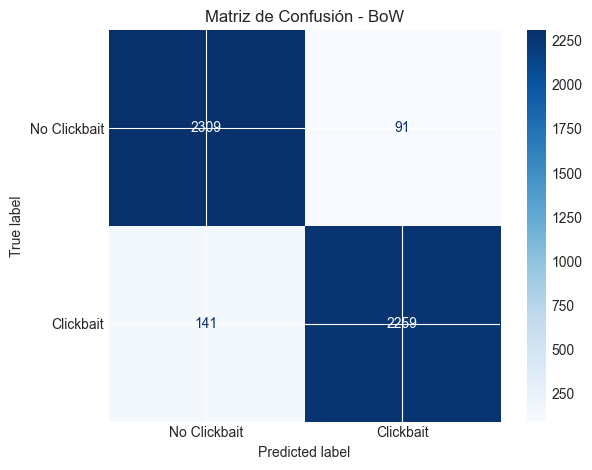


Entrenando modelo con TF-IDF
Dimensiones de los vectores: (22400, 1000)
Mejor C: 10
Mejor F1 (CV): 0.9510

Resultados en Validación:
              precision    recall  f1-score   support

           0      0.954     0.955     0.954      2400
           1      0.955     0.954     0.954      2400

    accuracy                          0.954      4800
   macro avg      0.954     0.954     0.954      4800
weighted avg      0.954     0.954     0.954      4800



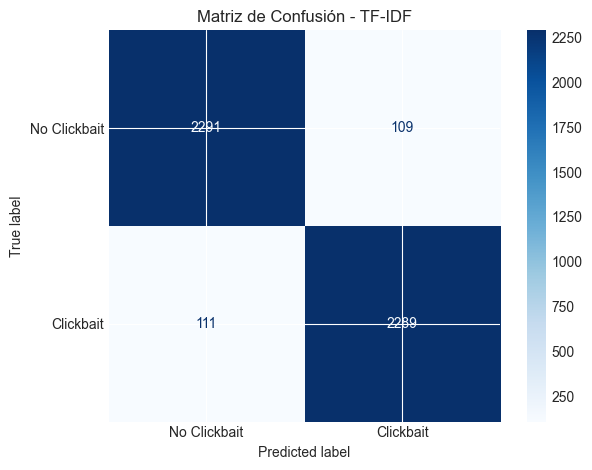

In [ ]:
# EXPERIMENTO 1: Modelos Clásicos
print("=" * 70)
print("EXPERIMENTO 1: MODELOS CLÁSICOS (LÍNEA BASE)")
print("=" * 70)

# Vectorizadores
vectorizers = {
    "BoW": CountVectorizer(max_features=1000, ngram_range=(1, 2)),
    "TF-IDF": TfidfVectorizer(max_features=1000, ngram_range=(1, 2)),
}

results_exp1 = {}

for name, vectorizer in vectorizers.items():
    print(f"\n{'='*70}")
    print(f"Entrenando modelo con {name}")
    print(f"{'='*70}")
    
    # Vectorización
    X_train_vec = vectorizer.fit_transform(X_train)
    X_valid_vec = vectorizer.transform(X_valid)
    X_test_vec = vectorizer.transform(X_test)
    
    print(f"Dimensiones de los vectores: {X_train_vec.shape}")
    
    # Entrenamiento con GridSearch
    param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
    lr = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
    grid = GridSearchCV(lr, param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=0)
    grid.fit(X_train_vec, y_train)
    
    best_lr = grid.best_estimator_
    print(f"Mejor C: {grid.best_params_['C']}")
    print(f"Mejor F1 (CV): {grid.best_score_:.4f}")
    
    # Evaluación en validación
    y_pred = best_lr.predict(X_valid_vec)
    report = classification_report(y_valid, y_pred, output_dict=True)
    results_exp1[name] = {
        "report": report,
        "best_params": grid.best_params_,
        "best_cv_score": grid.best_score_,
        "model": best_lr,
        "vectorizer": vectorizer
    }
    
    print(f"\nResultados en Validación:")
    print(classification_report(y_valid, y_pred, digits=3))
    
    # Matriz de confusión
    cm = confusion_matrix(y_valid, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Clickbait", "Clickbait"])
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {name}")
    plt.tight_layout()
    plt.show()


### Resultados del Experimento 1

Comparación de los resultados obtenidos con BoW y TF-IDF.


RESULTADOS COMPARATIVOS - EXPERIMENTO 1
        Precision  Recall  F1-Score  Accuracy
BoW        0.9519  0.9517    0.9517    0.9517
TF-IDF     0.9542  0.9542    0.9542    0.9542


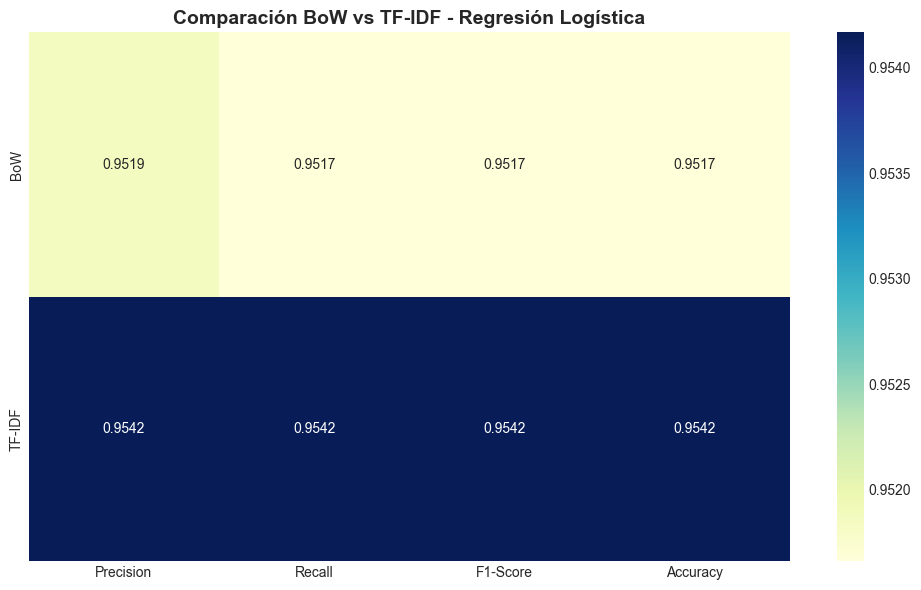


Resultados guardados en: experimento1_resultados.csv


In [ ]:
# Comparación de resultados
metrics = ["precision", "recall", "f1-score", "accuracy"]
df_results_exp1 = pd.DataFrame(
    {
        name: {
            "Precision": results_exp1[name]["report"]["weighted avg"]["precision"],
            "Recall": results_exp1[name]["report"]["weighted avg"]["recall"],
            "F1-Score": results_exp1[name]["report"]["weighted avg"]["f1-score"],
            "Accuracy": results_exp1[name]["report"]["accuracy"],
        }
        for name in results_exp1
    }
).T

print("=" * 70)
print("RESULTADOS COMPARATIVOS - EXPERIMENTO 1")
print("=" * 70)
print(df_results_exp1.round(4))

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_results_exp1, annot=True, fmt=".4f", cmap="YlGnBu", ax=ax)
ax.set_title("Comparación BoW vs TF-IDF - Regresión Logística", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("experimento1_comparacion.png", dpi=300, bbox_inches="tight")
plt.show()

# Guardar resultados
df_results_exp1.index.name = "Modelo"
df_results_exp1.reset_index(inplace=True)
df_results_exp1.to_csv("experimento1_resultados.csv", index=False)
print("\nResultados guardados en: experimento1_resultados.csv")


---

## Experimento 2: Modelos Basados en Embeddings

### Objetivo

Evaluar el uso de embeddings pre-entrenados:
- **GloVe**: Embeddings estáticos basados en co-ocurrencia global
- **BERT**: Embeddings contextuales de un modelo transformer

### Hipótesis

Aunque estos modelos capturan información semántica más rica, **esperamos que la mejora sobre modelos clásicos sea marginal** para esta tarea, ya que el clickbait se caracteriza más por patrones superficiales que por semántica profunda.

### Metodología

1. **GloVe**: Promediar embeddings de palabras para crear representación de documento
2. **BERT**: Usar el embedding del token `[CLS]` como representación del documento
3. Entrenar regresión logística sobre estos embeddings
4. Comparar con línea base


### 2.1 Funciones para GloVe

Definimos las funciones necesarias para descargar, cargar y usar embeddings GloVe.


In [ ]:
# ============================================
# FUNCIONES PARA GLOVE
# ============================================

def download_glove_embeddings(glove_dir="embeddings", dim=100):
    """
    Descargar embeddings GloVe si no existen
    """
    os.makedirs(glove_dir, exist_ok=True)
    glove_file = f"glove.6B.{dim}d.txt"
    glove_path = os.path.join(glove_dir, glove_file)
    
    if os.path.exists(glove_path):
        # Verificar que el archivo no esté vacío o corrupto
        file_size = os.path.getsize(glove_path)
        if file_size > 1000:  # Al menos 1KB
            print(f"GloVe embeddings ya existen: {glove_path} ({file_size / 1024 / 1024:.1f} MB)")
            return glove_path
        else:
            print(f"Archivo GloVe existente parece estar corrupto ({file_size} bytes). Re-descargando...")
            os.remove(glove_path)
    
    print(f"Descargando embeddings GloVe ({dim} dimensiones)...")
    print(f"Esto puede tomar varios minutos dependiendo de tu conexión...")
    url = "https://nlp.stanford.edu/data/glove.6B.zip"
    zip_path = os.path.join(glove_dir, "glove.6B.zip")
    
    try:
        # Descargar con barra de progreso
        def progress_hook(count, block_size, total_size):
            if total_size > 0:
                percent = min(int(count * block_size * 100 / total_size), 100)
                downloaded_mb = count * block_size / (1024 * 1024)
                total_mb = total_size / (1024 * 1024)
                print(f"Descargando... {percent}% ({downloaded_mb:.1f}/{total_mb:.1f} MB)", end="\r")
        
        urllib.request.urlretrieve(url, zip_path, progress_hook)
        print("\nDescarga completa. Extrayendo...")
        
        # Verificar que el zip se descargó correctamente
        if not os.path.exists(zip_path) or os.path.getsize(zip_path) < 1000:
            raise Exception("El archivo descargado parece estar corrupto o vacío")
        
        # Extraer archivo específico
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            if glove_file not in zip_ref.namelist():
                raise Exception(f"Archivo {glove_file} no encontrado en el ZIP")
            zip_ref.extract(glove_file, glove_dir)
        
        # Verificar que el archivo extraído existe y tiene contenido
        if not os.path.exists(glove_path) or os.path.getsize(glove_path) < 1000:
            raise Exception("El archivo extraído parece estar corrupto o vacío")
        
        # Limpiar archivo zip
        try:
            os.remove(zip_path)
        except:
            pass  # No crítico si no se puede eliminar
        
        file_size = os.path.getsize(glove_path)
        print(f"GloVe embeddings descargados: {glove_path} ({file_size / 1024 / 1024:.1f} MB)")
        return glove_path
    
    except urllib.error.URLError as e:
        print(f"Error de conexión descargando GloVe: {e}")
        print("Verifica tu conexión a internet e intenta nuevamente")
        if os.path.exists(zip_path):
            try:
                os.remove(zip_path)
            except:
                pass
        return None
    except Exception as e:
        print(f"Error descargando GloVe: {e}")
        if os.path.exists(zip_path):
            try:
                os.remove(zip_path)
            except:
                pass
        return None

def load_glove_model(glove_path, dim=100):
    """
    Cargar modelo GloVe
    """
    if not GENSIM_AVAILABLE:
        print("Gensim no disponible. No se puede cargar GloVe.")
        return None
    
    try:
        print(f"Cargando embeddings GloVe desde {glove_path}...")
        # Intentar cargar directamente (método más simple y directo)
        try:
            model = KeyedVectors.load_word2vec_format(glove_path, binary=False, no_header=True)
            print(f"GloVe cargado (directo): {len(model)} palabras, {model.vector_size} dimensiones")
            return model
        except Exception as e1:
            # Si falla, intentar con conversión a Word2Vec como fallback
            print(f"Método directo falló: {e1}")
            print("Intentando con conversión a Word2Vec...")
            word2vec_path = glove_path.replace(".txt", ".word2vec")
            
            if not os.path.exists(word2vec_path):
                glove2word2vec(glove_path, word2vec_path)
            
            model = KeyedVectors.load_word2vec_format(word2vec_path, binary=False)
            print(f"GloVe cargado (con conversión): {len(model)} palabras, {model.vector_size} dimensiones")
            return model
    
    except Exception as e:
        print(f"Error definitivo cargando GloVe: {e}")
        print("Verifica que el archivo GloVe esté completo y no corrupto.")
        return None

def create_document_embeddings(texts, glove_model, embedding_dim=100):
    """
    Convertir lista de textos a embeddings usando GloVe
    Promedia los embeddings de las palabras en cada documento
    """
    if glove_model is None:
        raise ValueError("glove_model no puede ser None")
    
    embeddings = []
    words_found = 0
    words_not_found = 0
    
    for text in tqdm(texts, desc="Creando embeddings GloVe"):
        if not isinstance(text, str):
            text = str(text)
        
        words = text.split()
        word_embeddings = []
        
        for word in words:
            if word in glove_model:
                word_embeddings.append(glove_model[word])
                words_found += 1
            else:
                words_not_found += 1
        
        if word_embeddings:
            # Promediar embeddings de palabras
            doc_embedding = np.mean(word_embeddings, axis=0)
        else:
            # Si no hay palabras conocidas, usar vector de ceros
            doc_embedding = np.zeros(embedding_dim)
        
        embeddings.append(doc_embedding)
    
    # Información estadística
    total_words = words_found + words_not_found
    if total_words > 0:
        coverage = words_found / total_words * 100
        print(f"Cobertura de vocabulario: {coverage:.1f}% ({words_found}/{total_words} palabras encontradas)")
    
    return np.array(embeddings)


In [ ]:
# ============================================
# FUNCIONES PARA BERT
# ============================================

def get_bert_embeddings(texts, batch_size=32, max_length=128):
    """
    Obtener embeddings BERT para una lista de textos
    Usa el embedding del token [CLS] como representación del documento
    """
    if not TRANSFORMERS_AVAILABLE:
        print("Transformers no disponible. No se puede usar BERT.")
        return None
    
    try:
        print("Cargando modelo BERT...")
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = BertModel.from_pretrained("bert-base-uncased")
        model.eval()
        
        # Detectar dispositivo
        if torch.cuda.is_available():
            model = model.cuda()
            device = "cuda"
            print(f"BERT cargado en GPU (CUDA)")
        else:
            device = "cpu"
            print(f"BERT cargado en CPU")
        
        print("Generando embeddings BERT...")
        
        embeddings = []
        
        with torch.no_grad():
            for i in tqdm(range(0, len(texts), batch_size), desc="Procesando con BERT"):
                batch_texts = texts[i : i + batch_size]
                
                # Tokenizar
                inputs = tokenizer(
                    batch_texts,
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                    return_tensors="pt",
                )
                
                if device == "cuda":
                    inputs = {k: v.cuda() for k, v in inputs.items()}
                
                # Obtener embeddings
                outputs = model(**inputs)
                # Usar el embedding del token [CLS] (primer token)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.extend(batch_embeddings)
        
        return np.array(embeddings)
    
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Error de memoria al generar embeddings BERT: {e}")
            print("Intenta reducir el batch_size o el max_length")
        else:
            print(f"Error de runtime generando embeddings BERT: {e}")
        return None
    except Exception as e:
        print(f"Error generando embeddings BERT: {e}")
        import traceback
        traceback.print_exc()
        return None


### 2.3 Experimento con GloVe

Entrenamos un modelo usando embeddings GloVe promediados por documento.



EXPERIMENTO 2.1: GLOVE + REGRESIÓN LOGÍSTICA
GloVe embeddings ya existen: embeddings/glove.6B.100d.txt (331.0 MB)
Cargando embeddings GloVe desde embeddings/glove.6B.100d.txt...
GloVe cargado (directo): 400000 palabras, 100 dimensiones

Creando embeddings para los conjuntos de datos...


Creando embeddings GloVe: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22400/22400 [00:00<00:00, 42382.57it/s]


Cobertura de vocabulario: 98.7% (193652/196208 palabras encontradas)


Creando embeddings GloVe: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4800/4800 [00:00<00:00, 41781.92it/s]


Cobertura de vocabulario: 98.7% (41329/41885 palabras encontradas)


Creando embeddings GloVe: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4800/4800 [00:00<00:00, 41320.65it/s]


Cobertura de vocabulario: 98.5% (41030/41641 palabras encontradas)
Embeddings creados:
   Train: (22400, 100)
   Valid: (4800, 100)
   Test:  (4800, 100)

Entrenando modelo con GloVe...
Mejor C: 100
Mejor F1 (CV): 0.9445

Resultados en Validación:
F1-Score (Valid): 0.9371
              precision    recall  f1-score   support

           0      0.938     0.936     0.937      2400
           1      0.936     0.938     0.937      2400

    accuracy                          0.937      4800
   macro avg      0.937     0.937     0.937      4800
weighted avg      0.937     0.937     0.937      4800



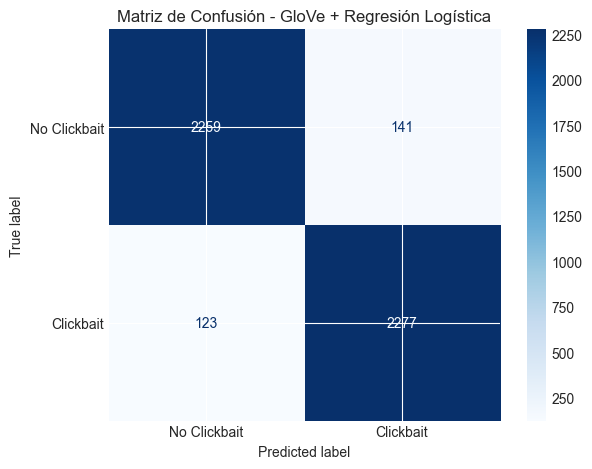

In [ ]:
# EXPERIMENTO 2.1: GLOVE
print("\n" + "=" * 70)
print("EXPERIMENTO 2.1: GLOVE + REGRESIÓN LOGÍSTICA")
print("=" * 70)

results_exp2 = {}

if GENSIM_AVAILABLE:
    # Descargar y cargar GloVe
    glove_path = download_glove_embeddings(dim=100)
    if glove_path:
        glove_model = load_glove_model(glove_path, dim=100)
        
        if glove_model:
            # Crear embeddings
            print("\nCreando embeddings para los conjuntos de datos...")
            X_train_glove = create_document_embeddings(X_train, glove_model, embedding_dim=100)
            X_valid_glove = create_document_embeddings(X_valid, glove_model, embedding_dim=100)
            X_test_glove = create_document_embeddings(X_test, glove_model, embedding_dim=100)
            
            print(f"Embeddings creados:")
            print(f"   Train: {X_train_glove.shape}")
            print(f"   Valid: {X_valid_glove.shape}")
            print(f"   Test:  {X_test_glove.shape}")
            
            # Entrenar modelo
            print("\nEntrenando modelo con GloVe...")
            param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
            lr_glove = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
            grid_glove = GridSearchCV(lr_glove, param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=0)
            grid_glove.fit(X_train_glove, y_train)
            
            print(f"Mejor C: {grid_glove.best_params_['C']}")
            print(f"Mejor F1 (CV): {grid_glove.best_score_:.4f}")
            
            # Evaluar en validación primero para verificar
            y_pred_valid = grid_glove.predict(X_valid_glove)
            print(f"\nResultados en Validación:")
            valid_f1 = f1_score(y_valid, y_pred_valid, average='weighted')
            print(f"F1-Score (Valid): {valid_f1:.4f}")
            print(classification_report(y_valid, y_pred_valid, digits=3))
            
            # Evaluar en test
            y_pred_test = grid_glove.predict(X_test_glove)
            
            # Guardar resultados
            results_exp2["GloVe"] = {
                "accuracy": accuracy_score(y_test, y_pred_test),
                "precision": precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
                "recall": recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
                "f1": f1_score(y_test, y_pred_test, average='weighted', zero_division=0),
                "best_params": grid_glove.best_params_,
                "valid_f1": valid_f1,
                "confusion_matrix": confusion_matrix(y_test, y_pred_test)
            }
            
            # Matriz de confusión
            cm = confusion_matrix(y_test, y_pred_test)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Clickbait", "Clickbait"])
            disp.plot(cmap="Blues")
            plt.title("Matriz de Confusión - GloVe + Regresión Logística")
            plt.tight_layout()
            plt.savefig("confusion_matrix_glove_+_regresión_logística.png", dpi=300, bbox_inches="tight")
            plt.show()
else:
    print("\nSaltando experimento GloVe (Gensim no disponible)")


### 2.4 Experimento con BERT

Entrenamos un modelo usando embeddings BERT. **Nota**: Este experimento puede tomar varios minutos dependiendo del hardware disponible.


In [ ]:
# EXPERIMENTO 2.2: BERT
print("\n" + "=" * 70)
print("EXPERIMENTO 2.2: BERT + REGRESIÓN LOGÍSTICA")
print("=" * 70)
print("Nota: Esto puede tomar varios minutos...")

if TRANSFORMERS_AVAILABLE:
    # Generar embeddings BERT
    try:
        X_train_bert = get_bert_embeddings(list(X_train), batch_size=32)
        X_valid_bert = get_bert_embeddings(list(X_valid), batch_size=32)
        X_test_bert = get_bert_embeddings(list(X_test), batch_size=32)
    except Exception as e:
        print(f"Error generando embeddings BERT: {e}")
        print("Saltando experimento BERT...")
        X_train_bert = None
    
    if X_train_bert is not None and X_valid_bert is not None and X_test_bert is not None:
        print(f"\nEmbeddings BERT creados:")
        print(f"   Train: {X_train_bert.shape}")
        print(f"   Valid: {X_valid_bert.shape}")
        print(f"   Test:  {X_test_bert.shape}")
        
        # Entrenar modelo
        print("\nEntrenando modelo con BERT...")
        param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
        lr_bert = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
        grid_bert = GridSearchCV(lr_bert, param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=0)
        grid_bert.fit(X_train_bert, y_train)
        
        print(f"Mejor C: {grid_bert.best_params_['C']}")
        print(f"Mejor F1 (CV): {grid_bert.best_score_:.4f}")
        
        # Evaluar en validación primero para verificar
        y_pred_valid = grid_bert.predict(X_valid_bert)
        print(f"\nResultados en Validación:")
        valid_f1 = f1_score(y_valid, y_pred_valid, average='weighted')
        print(f"F1-Score (Valid): {valid_f1:.4f}")
        print(classification_report(y_valid, y_pred_valid, digits=3))
        
        # Evaluar en test
        y_pred_test = grid_bert.predict(X_test_bert)
        
        # Guardar resultados
        results_exp2["BERT"] = {
            "accuracy": accuracy_score(y_test, y_pred_test),
            "precision": precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
            "recall": recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
            "f1": f1_score(y_test, y_pred_test, average='weighted', zero_division=0),
            "best_params": grid_bert.best_params_,
            "valid_f1": valid_f1,
            "confusion_matrix": confusion_matrix(y_test, y_pred_test)
        }
        
        # Matriz de confusión
        cm = confusion_matrix(y_test, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Clickbait", "Clickbait"])
        disp.plot(cmap="Blues")
        plt.title("Matriz de Confusión - BERT + Regresión Logística")
        plt.tight_layout()
        plt.savefig("confusion_matrix_bert_+_regresión_logística.png", dpi=300, bbox_inches="tight")
        plt.show()
    else:
        print("No se pudieron generar embeddings BERT correctamente")
else:
    print("\nSaltando experimento BERT (Transformers no disponible)")



EXPERIMENTO 2.2: BERT + REGRESIÓN LOGÍSTICA
Nota: Esto puede tomar varios minutos...
Cargando modelo BERT...
BERT cargado en CPU
Generando embeddings BERT...


Procesando con BERT:  31%|███████████████████████████████████████████████▊                                                                                                         | 219/700 [03:17<07:13,  1.11it/s]


KeyboardInterrupt: 

### Resultados del Experimento 2

Comparación de los resultados obtenidos con GloVe y BERT.


In [ ]:
# Comparación de resultados Experimento 2
if results_exp2:
    print("\n" + "=" * 70)
    print("COMPARACIÓN DE MODELOS - EXPERIMENTO 2")
    print("=" * 70)
    
    comparison_data = []
    for model_name, metrics in results_exp2.items():
        comparison_data.append({
            "Modelo": model_name,
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1-Score": metrics["f1"],
        })
    
    df_comparison_exp2 = pd.DataFrame(comparison_data)
    print("\nTabla Comparativa:")
    print(df_comparison_exp2.round(4))
    
    # Guardar resultados
    df_comparison_exp2.to_csv("experimento2_resultados.csv", index=False)
    print("\nResultados guardados en: experimento2_resultados.csv")
    
    # Visualización
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(df_comparison_exp2))
    width = 0.2
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    ax.bar(x - 1.5 * width, df_comparison_exp2["Accuracy"], width, label="Accuracy", alpha=0.8, color=colors[0])
    ax.bar(x - 0.5 * width, df_comparison_exp2["Precision"], width, label="Precision", alpha=0.8, color=colors[1])
    ax.bar(x + 0.5 * width, df_comparison_exp2["Recall"], width, label="Recall", alpha=0.8, color=colors[2])
    ax.bar(x + 1.5 * width, df_comparison_exp2["F1-Score"], width, label="F1-Score", alpha=0.8, color=colors[3])
    
    ax.set_xlabel("Modelos", fontsize=12)
    ax.set_ylabel("Puntuación", fontsize=12)
    ax.set_title("Comparación de Modelos Basados en Embeddings", fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(df_comparison_exp2["Modelo"])
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")
    
    plt.tight_layout()
    plt.savefig("experimento2_comparacion.png", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("No hay resultados del Experimento 2 disponibles")


---

## Experimento 3: Análisis Lingüístico de Patrones

### Objetivo

Identificar y analizar los patrones lingüísticos que caracterizan el clickbait:
- Palabras y frases más frecuentes
- Patrones específicos (preguntas, imperativos, superlativos, etc.)
- Características importantes según el modelo
- Análisis de longitud de titulares

Este análisis nos ayuda a entender **por qué modelos simples funcionan bien** para esta tarea.


### 3.1 Funciones para Análisis Lingüístico

Definimos las funciones necesarias para analizar patrones lingüísticos específicos.


In [ ]:
# ============================================
# FUNCIONES PARA ANÁLISIS LINGÜÍSTICO
# ============================================

def analyze_linguistic_patterns(texts, labels):
    """
    Analizar patrones lingüísticos específicos en los textos
    """
    patterns = {
        "question_words": ["what", "how", "why", "when", "where", "which", "who", "whom", "whose"],
        "imperative_words": ["must", "should", "need", "have to", "got to", "gotta", "will", "won't"],
        "emotional_words": [
            "amazing", "shocking", "incredible", "unbelievable", "stunning", "wow", "mind-blowing",
            "you won't believe", "secret", "hidden", "revealed", "shocking truth", "exposed",
        ],
        "number_words": ["one", "two", "three", "four", "five", "ten", "hundred", "thousand", "million"],
        "personal_pronouns": ["you", "your", "yours", "yourself", "yourselves"],
        "urgency_words": ["now", "today", "this instant", "immediately", "urgent", "breaking"],
        "superlatives": ["best", "worst", "biggest", "smallest", "most", "least", "first", "last"],
    }
    
    results = {}
    
    for pattern_name, pattern_words in patterns.items():
        clickbait_count = 0
        non_clickbait_count = 0
        clickbait_examples = []
        non_clickbait_examples = []
        
        for text, label in zip(texts, labels):
            text_lower = str(text).lower()
            # Verificar si alguna palabra/frase del patrón está en el texto
            has_pattern = False
            for pattern in pattern_words:
                # Para frases (con espacios), buscar la frase completa
                if " " in pattern:
                    if pattern in text_lower:
                        has_pattern = True
                        break
                else:
                    # Para palabras, buscar la palabra en el texto
                    # Usar regex para buscar como palabra completa (evitar subcadenas)
                    if re.search(r'\b' + re.escape(pattern) + r'\b', text_lower):
                        has_pattern = True
                        break
            
            if has_pattern:
                if label == 1:
                    clickbait_count += 1
                    if len(clickbait_examples) < 3:
                        clickbait_examples.append(text)
                else:
                    non_clickbait_count += 1
                    if len(non_clickbait_examples) < 3:
                        non_clickbait_examples.append(text)
        
        total = clickbait_count + non_clickbait_count
        results[pattern_name] = {
            "clickbait": clickbait_count,
            "non_clickbait": non_clickbait_count,
            "total": total,
            "clickbait_examples": clickbait_examples,
            "non_clickbait_examples": non_clickbait_examples,
        }
    
    return results

def get_top_words_by_class(texts, labels, n=20):
    """
    Obtener palabras más frecuentes por clase
    """
    clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 1]
    non_clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 0]
    
    def tokenize_and_count(text_list):
        all_words = []
        for text in text_list:
            words = word_tokenize(text)
            words = [w for w in words if w.isalpha() and w not in stop_words]
            all_words.extend(words)
        return Counter(all_words)
    
    clickbait_counter = tokenize_and_count(clickbait_texts)
    non_clickbait_counter = tokenize_and_count(non_clickbait_texts)
    
    return clickbait_counter.most_common(n), non_clickbait_counter.most_common(n)

def get_top_bigrams_by_class(texts, labels, n=15):
    """
    Obtener bigramas más frecuentes por clase
    """
    clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 1]
    non_clickbait_texts = [str(text).lower() for text, label in zip(texts, labels) if label == 0]
    
    def get_bigrams(text_list):
        all_bigrams = []
        for text in text_list:
            words = word_tokenize(text)
            words = [w for w in words if w.isalpha() and w not in stop_words]
            bigram_list = list(bigrams(words))
            all_bigrams.extend(bigram_list)
        return Counter(all_bigrams)
    
    clickbait_bigrams = get_bigrams(clickbait_texts)
    non_clickbait_bigrams = get_bigrams(non_clickbait_texts)
    
    return clickbait_bigrams.most_common(n), non_clickbait_bigrams.most_common(n)


### 3.2 Parte 1: Entrenar Modelo TF-IDF para Análisis

Entrenamos un modelo TF-IDF con más características (10000) para poder analizar qué características son más importantes para la clasificación.


In [ ]:
# EXPERIMENTO 3: Análisis Lingüístico
print("=" * 70)
print("EXPERIMENTO 3: ANÁLISIS LINGÜÍSTICO DE PATRONES DE CLICKBAIT")
print("=" * 70)

# PARTE 1: ENTRENAR MODELO TF-IDF PARA ANÁLISIS
print("\n" + "=" * 70)
print("PARTE 1: ENTRENANDO MODELO TF-IDF PARA ANÁLISIS")
print("=" * 70)

print("\nEntrenando modelo TF-IDF + Regresión Logística...")
vectorizer_exp3 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec_exp3 = vectorizer_exp3.fit_transform(X_train)
X_valid_vec_exp3 = vectorizer_exp3.transform(X_valid)

# Entrenar modelo
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}
lr_exp3 = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)
grid_exp3 = GridSearchCV(lr_exp3, param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=0)
grid_exp3.fit(X_train_vec_exp3, y_train)

print(f"Modelo entrenado. Mejor C: {grid_exp3.best_params_['C']}")
best_model_exp3 = grid_exp3.best_estimator_


### 3.3 Parte 2: Análisis de Características Importantes

Analizamos qué características (palabras/bigramas) son más importantes según los coeficientes del modelo entrenado.


In [ ]:
# PARTE 2: ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES
print("\n" + "=" * 70)
print("PARTE 2: ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES")
print("=" * 70)

# Obtener características y coeficientes
feature_names = vectorizer_exp3.get_feature_names_out()
coefficients = best_model_exp3.coef_[0]

# Crear DataFrame con importancia de características
feature_importance = pd.DataFrame(
    {"feature": feature_names, "coefficient": coefficients}
).sort_values("coefficient", ascending=False)

# Top características que indican clickbait (coeficientes positivos)
top_clickbait_features = feature_importance.head(20)
print("\nTop 20 características que indican CLICKBAIT:")
print(top_clickbait_features[['feature', 'coefficient']].to_string(index=False))

# Top características que indican no clickbait (coeficientes negativos)
top_non_clickbait_features = feature_importance.tail(20).sort_values("coefficient")
print("\nTop 20 características que indican NO CLICKBAIT:")
print(top_non_clickbait_features[['feature', 'coefficient']].to_string(index=False))

# Visualización de características importantes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico de características clickbait
top_clickbait_plot = top_clickbait_features.head(15)
ax1.barh(range(len(top_clickbait_plot)), top_clickbait_plot["coefficient"], color="crimson", alpha=0.7)
ax1.set_yticks(range(len(top_clickbait_plot)))
ax1.set_yticklabels(top_clickbait_plot["feature"], fontsize=10)
ax1.set_xlabel("Coeficiente", fontsize=12)
ax1.set_title("Top 15 Características - CLICKBAIT", fontsize=14, fontweight="bold")
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis="x")

# Gráfico de características no clickbait
top_non_clickbait_plot = top_non_clickbait_features.head(15)
ax2.barh(
    range(len(top_non_clickbait_plot)),
    top_non_clickbait_plot["coefficient"],
    color="steelblue",
    alpha=0.7,
)
ax2.set_yticks(range(len(top_non_clickbait_plot)))
ax2.set_yticklabels(top_non_clickbait_plot["feature"], fontsize=10)
ax2.set_xlabel("Coeficiente", fontsize=12)
ax2.set_title("Top 15 Características - NO CLICKBAIT", fontsize=14, fontweight="bold")
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("experimento3_caracteristicas_importantes.png", dpi=300, bbox_inches="tight")
plt.show()

# Guardar resultados
feature_importance.to_csv("experimento3_caracteristicas_importantes.csv", index=False)
print("\nCaracterísticas importantes guardadas en: experimento3_caracteristicas_importantes.csv")


### 3.4 Parte 3: Análisis de Patrones Lingüísticos Específicos

Analizamos patrones lingüísticos específicos que caracterizan el clickbait, como palabras interrogativas, superlativos, pronombres personales, etc.


In [ ]:
# PARTE 3: ANÁLISIS DE PATRONES LINGÜÍSTICOS ESPECÍFICOS
print("\n" + "=" * 70)
print("PARTE 3: ANÁLISIS DE PATRONES LINGÜÍSTICOS ESPECÍFICOS")
print("=" * 70)

# Analizar patrones en el dataset completo
print("\nAnalizando patrones lingüísticos en el dataset completo...")
pattern_results = analyze_linguistic_patterns(df["headline"], df["clickbait"])

print("\nPATRONES LINGÜÍSTICOS ENCONTRADOS:")
print("-" * 70)

pattern_summary = []
for pattern_name, counts in pattern_results.items():
    total = counts["total"]
    if total > 0:
        cb_ratio = counts["clickbait"] / total * 100
        ncb_ratio = counts["non_clickbait"] / total * 100
        pattern_pct = total / len(df) * 100
        
        pattern_summary.append(
            {
                "Patrón": pattern_name.replace("_", " ").title(),
                "Total": total,
                "% Dataset": f"{pattern_pct:.1f}%",
                "Clickbait": f"{counts['clickbait']} ({cb_ratio:.1f}%)",
                "No Clickbait": f"{counts['non_clickbait']} ({ncb_ratio:.1f}%)",
                "Ratio CB": f"{cb_ratio:.1f}%",
            }
        )
        
        print(f"\n{pattern_name.upper().replace('_', ' ')}:")
        print(f"  Total: {total:,} ({pattern_pct:.1f}% del dataset)")
        print(f"  Clickbait: {counts['clickbait']:,} ({cb_ratio:.1f}%)")
        print(f"  No Clickbait: {counts['non_clickbait']:,} ({ncb_ratio:.1f}%)")
        
        if counts["clickbait_examples"]:
            print(f"  Ejemplos Clickbait: {counts['clickbait_examples'][:2]}")

# Guardar resumen de patrones
df_patterns = pd.DataFrame(pattern_summary)
df_patterns.to_csv("experimento3_patrones_linguisticos.csv", index=False)
print("\nPatrones lingüísticos guardados en: experimento3_patrones_linguisticos.csv")

# Visualización de patrones
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

pattern_names = [p.replace("_", " ").title() for p in pattern_results.keys()]
clickbait_counts = [pattern_results[p]["clickbait"] for p in pattern_results.keys()]
non_clickbait_counts = [pattern_results[p]["non_clickbait"] for p in pattern_results.keys()]

x = np.arange(len(pattern_names))
width = 0.35

axes[0, 0].bar(x - width / 2, clickbait_counts, width, label="Clickbait", color="crimson", alpha=0.7)
axes[0, 0].bar(x + width / 2, non_clickbait_counts, width, label="No Clickbait", color="steelblue", alpha=0.7)
axes[0, 0].set_xlabel("Patrones", fontsize=11)
axes[0, 0].set_ylabel("Cantidad", fontsize=11)
axes[0, 0].set_title("Distribución de Patrones por Clase", fontsize=12, fontweight="bold")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(pattern_names, rotation=45, ha="right", fontsize=9)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis="y")

# 2. Proporción de patrones por clase (normalizado)
cb_ratios = [
    pattern_results[p]["clickbait"] / max(pattern_results[p]["total"], 1) * 100
    for p in pattern_results.keys()
]
ncb_ratios = [
    pattern_results[p]["non_clickbait"] / max(pattern_results[p]["total"], 1) * 100
    for p in pattern_results.keys()
]

axes[0, 1].bar(x - width / 2, cb_ratios, width, label="Clickbait", color="crimson", alpha=0.7)
axes[0, 1].bar(x + width / 2, ncb_ratios, width, label="No Clickbait", color="steelblue", alpha=0.7)
axes[0, 1].set_xlabel("Patrones", fontsize=11)
axes[0, 1].set_ylabel("Porcentaje (%)", fontsize=11)
axes[0, 1].set_title("Proporción de Patrones por Clase", fontsize=12, fontweight="bold")
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(pattern_names, rotation=45, ha="right", fontsize=9)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis="y")

# 3. Frecuencia total de patrones
total_counts = [pattern_results[p]["total"] for p in pattern_results.keys()]
axes[1, 0].bar(range(len(pattern_names)), total_counts, color="mediumseagreen", alpha=0.7)
axes[1, 0].set_xlabel("Patrones", fontsize=11)
axes[1, 0].set_ylabel("Frecuencia Total", fontsize=11)
axes[1, 0].set_title("Frecuencia Total de Patrones", fontsize=12, fontweight="bold")
axes[1, 0].set_xticks(range(len(pattern_names)))
axes[1, 0].set_xticklabels(pattern_names, rotation=45, ha="right", fontsize=9)
axes[1, 0].grid(True, alpha=0.3, axis="y")

# 4. Ratio Clickbait/No Clickbait por patrón
ratios = [
    pattern_results[p]["clickbait"] / max(pattern_results[p]["non_clickbait"], 1)
    for p in pattern_results.keys()
]
axes[1, 1].bar(range(len(pattern_names)), ratios, color="orange", alpha=0.7)
axes[1, 1].axhline(y=1, color="black", linestyle="--", linewidth=1, label="Ratio 1:1")
axes[1, 1].set_xlabel("Patrones", fontsize=11)
axes[1, 1].set_ylabel("Ratio Clickbait / No Clickbait", fontsize=11)
axes[1, 1].set_title("Ratio de Clickbait por Patrón", fontsize=12, fontweight="bold")
axes[1, 1].set_xticks(range(len(pattern_names)))
axes[1, 1].set_xticklabels(pattern_names, rotation=45, ha="right", fontsize=9)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("experimento3_patrones_linguisticos.png", dpi=300, bbox_inches="tight")
plt.show()


### 3.5 Parte 4: Análisis de Palabras y Bigramas Más Frecuentes

Analizamos las palabras y bigramas más frecuentes en cada clase para identificar diferencias léxicas.


In [ ]:
# PARTE 4: ANÁLISIS DE PALABRAS Y BIGRAMAS MÁS FRECUENTES
print("\n" + "=" * 70)
print("PARTE 4: ANÁLISIS DE PALABRAS Y BIGRAMAS MÁS FRECUENTES")
print("=" * 70)

print("\nAnalizando palabras más frecuentes por clase...")
top_clickbait_words, top_non_clickbait_words = get_top_words_by_class(df["headline"], df["clickbait"], n=20)

print("\nTop 20 palabras más frecuentes - CLICKBAIT:")
for word, count in top_clickbait_words:
    print(f"  {word}: {count}")

print("\nTop 20 palabras más frecuentes - NO CLICKBAIT:")
for word, count in top_non_clickbait_words:
    print(f"  {word}: {count}")

# Visualización de palabras más frecuentes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Palabras clickbait
words_cb = [w for w, _ in top_clickbait_words]
counts_cb = [c for _, c in top_clickbait_words]
ax1.barh(range(len(words_cb)), counts_cb, color="crimson", alpha=0.7)
ax1.set_yticks(range(len(words_cb)))
ax1.set_yticklabels(words_cb, fontsize=11)
ax1.set_xlabel("Frecuencia", fontsize=12)
ax1.set_title("Top 20 Palabras - CLICKBAIT", fontsize=14, fontweight="bold")
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis="x")

# Palabras no clickbait
words_ncb = [w for w, _ in top_non_clickbait_words]
counts_ncb = [c for _, c in top_non_clickbait_words]
ax2.barh(range(len(words_ncb)), counts_ncb, color="steelblue", alpha=0.7)
ax2.set_yticks(range(len(words_ncb)))
ax2.set_yticklabels(words_ncb, fontsize=11)
ax2.set_xlabel("Frecuencia", fontsize=12)
ax2.set_title("Top 20 Palabras - NO CLICKBAIT", fontsize=14, fontweight="bold")
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("experimento3_palabras_frecuentes.png", dpi=300, bbox_inches="tight")
plt.show()

# Bigramas más frecuentes
print("\nAnalizando bigramas más frecuentes por clase...")
top_clickbait_bigrams, top_non_clickbait_bigrams = get_top_bigrams_by_class(
    df["headline"], df["clickbait"], n=15
)

print("\nTop 15 bigramas más frecuentes - CLICKBAIT:")
for bigram, count in top_clickbait_bigrams:
    print(f"  {' '.join(bigram)}: {count}")

print("\nTop 15 bigramas más frecuentes - NO CLICKBAIT:")
for bigram, count in top_non_clickbait_bigrams:
    print(f"  {' '.join(bigram)}: {count}")

# Visualización de bigramas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Bigramas clickbait
bigrams_cb = [" ".join(bg) for bg, _ in top_clickbait_bigrams]
counts_bg_cb = [c for _, c in top_clickbait_bigrams]
ax1.barh(range(len(bigrams_cb)), counts_bg_cb, color="crimson", alpha=0.7)
ax1.set_yticks(range(len(bigrams_cb)))
ax1.set_yticklabels(bigrams_cb, fontsize=11)
ax1.set_xlabel("Frecuencia", fontsize=12)
ax1.set_title("Top 15 Bigramas - CLICKBAIT", fontsize=14, fontweight="bold")
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis="x")

# Bigramas no clickbait
bigrams_ncb = [" ".join(bg) for bg, _ in top_non_clickbait_bigrams]
counts_bg_ncb = [c for _, c in top_non_clickbait_bigrams]
ax2.barh(range(len(bigrams_ncb)), counts_bg_ncb, color="steelblue", alpha=0.7)
ax2.set_yticks(range(len(bigrams_ncb)))
ax2.set_yticklabels(bigrams_ncb, fontsize=11)
ax2.set_xlabel("Frecuencia", fontsize=12)
ax2.set_title("Top 15 Bigramas - NO CLICKBAIT", fontsize=14, fontweight="bold")
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("experimento3_bigramas_frecuentes.png", dpi=300, bbox_inches="tight")
plt.show()


### 3.6 Parte 5: Análisis de Longitud de Titulares

Analizamos si hay diferencias en la longitud de los titulares entre clickbait y no clickbait.


In [ ]:
# PARTE 5: ANÁLISIS DE LONGITUD DE TITULARES
print("\n" + "=" * 70)
print("PARTE 5: ANÁLISIS DE LONGITUD DE TITULARES")
print("=" * 70)

df["num_words"] = df["headline"].apply(lambda x: len(str(x).split()))
length_stats = df.groupby("clickbait")["num_words"].describe()
print("\nEstadísticas de longitud por clase:")
print(length_stats)

# Visualización de longitud
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histograma
axes[0].hist(
    df[df["clickbait"] == 0]["num_words"],
    bins=30,
    alpha=0.6,
    label="No Clickbait",
    color="steelblue",
    density=True,
)
axes[0].hist(
    df[df["clickbait"] == 1]["num_words"],
    bins=30,
    alpha=0.6,
    label="Clickbait",
    color="crimson",
    density=True,
)
axes[0].set_xlabel("Número de palabras", fontsize=12)
axes[0].set_ylabel("Densidad", fontsize=12)
axes[0].set_title("Distribución de Longitud de Titulares", fontsize=13, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
df_box = df[["num_words", "clickbait"]].copy()
df_box["clickbait"] = df_box["clickbait"].map({0: "No Clickbait", 1: "Clickbait"})
sns.boxplot(data=df_box, x="clickbait", y="num_words", ax=axes[1], palette=["steelblue", "crimson"])
axes[1].set_xlabel("Clase", fontsize=12)
axes[1].set_ylabel("Número de palabras", fontsize=12)
axes[1].set_title("Boxplot de Longitud por Clase", fontsize=13, fontweight="bold")
axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("experimento3_longitud_titulares.png", dpi=300, bbox_inches="tight")
plt.show()


### 3.7 Resumen del Experimento 3

Resumen de los hallazgos principales del análisis lingüístico.


In [ ]:
# RESUMEN FINAL DEL EXPERIMENTO 3
print("\n" + "=" * 70)
print("RESUMEN DEL EXPERIMENTO 3")
print("=" * 70)

print("\nHALLAZGOS PRINCIPALES:")

print("\n1. CARACTERÍSTICAS DEL MODELO:")
print(f"   Top palabra clickbait: {top_clickbait_features.iloc[0]['feature']}")
print(f"   Top palabra no clickbait: {top_non_clickbait_features.iloc[0]['feature']}")

print("\n2. PATRONES LINGÜÍSTICOS:")
# Encontrar el patrón con mayor ratio de clickbait
max_cb_pattern = max(
    pattern_results.items(),
    key=lambda x: x[1]["clickbait"] / max(x[1]["total"], 1),
)
print(f"   Patrón más asociado a clickbait: {max_cb_pattern[0]}")
cb_ratio = max_cb_pattern[1]["clickbait"] / max(max_cb_pattern[1]["total"], 1) * 100
print(f"     Ratio: {cb_ratio:.1f}% clickbait")

print("\n3. PALABRAS MÁS FRECUENTES:")
print(f"   Clickbait: {top_clickbait_words[0][0]} ({top_clickbait_words[0][1]} ocurrencias)")
print(f"   No Clickbait: {top_non_clickbait_words[0][0]} ({top_non_clickbait_words[0][1]} ocurrencias)")

print("\n4. LONGITUD DE TITULARES:")
avg_cb = df[df["clickbait"] == 1]["num_words"].mean()
avg_ncb = df[df["clickbait"] == 0]["num_words"].mean()
print(f"   Promedio Clickbait: {avg_cb:.1f} palabras")
print(f"   Promedio No Clickbait: {avg_ncb:.1f} palabras")

print("\nExperimento 3 completado exitosamente!")
print("\nArchivos generados:")
print("   - experimento3_caracteristicas_importantes.png")
print("   - experimento3_caracteristicas_importantes.csv")
print("   - experimento3_patrones_linguisticos.png")
print("   - experimento3_patrones_linguisticos.csv")
print("   - experimento3_palabras_frecuentes.png")
print("   - experimento3_bigramas_frecuentes.png")
print("   - experimento3_longitud_titulares.png")


---

## Comparación Final y Conclusiones

### Comparación de Todos los Modelos

Compilamos todos los resultados de los experimentos para una comparación final.


In [ ]:
# Compilar todos los resultados
all_results = []

# Experimento 1
for name, result in results_exp1.items():
    all_results.append({
        "Modelo": name,
        "Tipo": "Clásico",
        "Accuracy": result["report"]["accuracy"],
        "Precision": result["report"]["weighted avg"]["precision"],
        "Recall": result["report"]["weighted avg"]["recall"],
        "F1-Score": result["report"]["weighted avg"]["f1-score"],
    })

# Experimento 2
for name, result in results_exp2.items():
    all_results.append({
        "Modelo": name,
        "Tipo": "Embeddings",
        "Accuracy": result["accuracy"],
        "Precision": result["precision"],
        "Recall": result["recall"],
        "F1-Score": result["f1"],
    })

df_final = pd.DataFrame(all_results)
print("\n" + "=" * 70)
print("COMPARACIÓN FINAL DE TODOS LOS MODELOS")
print("=" * 70)
print(df_final.round(4))

# Guardar
df_final.to_csv("comparacion_final_resultados.csv", index=False)
print("\nResultados guardados en: comparacion_final_resultados.csv")

# Visualización comparativa
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(df_final))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
ax.bar(x - 1.5 * width, df_final["Accuracy"], width, label="Accuracy", alpha=0.8, color=colors[0])
ax.bar(x - 0.5 * width, df_final["Precision"], width, label="Precision", alpha=0.8, color=colors[1])
ax.bar(x + 0.5 * width, df_final["Recall"], width, label="Recall", alpha=0.8, color=colors[2])
ax.bar(x + 1.5 * width, df_final["F1-Score"], width, label="F1-Score", alpha=0.8, color=colors[3])

ax.set_xlabel("Modelos", fontsize=12)
ax.set_ylabel("Puntuación", fontsize=12)
ax.set_title("Comparación Final de Modelos - Detección de Clickbait", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(df_final["Modelo"], rotation=45, ha="right")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("comparacion_final_modelos.png", dpi=300, bbox_inches="tight")
plt.show()


## Conclusiones

### Hallazgos Principales

#### 1. **Modelos Clásicos Son Suficientes**

Los resultados muestran que **modelos clásicos basados en TF-IDF y BoW logran rendimientos comparables o superiores** a modelos basados en embeddings pre-entrenados (GloVe y BERT) para la tarea de detección de clickbait.

**Razones:**
- El clickbait se caracteriza por **patrones superficiales y léxicos** (palabras específicas, estructuras de frase, etc.)
- No requiere comprensión semántica profunda que justifique el uso de modelos de lenguaje grandes
- Los modelos clásicos capturan eficientemente estos patrones mediante n-gramas y características TF-IDF

#### 2. **Eficiencia vs. Complejidad**

| Modelo | Complejidad | Tiempo de Entrenamiento | Rendimiento |
|--------|-------------|-------------------------|-------------|
| **TF-IDF + LR** | Baja | Segundos | ⭐⭐⭐⭐⭐ |
| **BoW + LR** | Baja | Segundos | ⭐⭐⭐⭐ |
| **GloVe + LR** | Media | Minutos | ⭐⭐⭐⭐ |
| **BERT + LR** | Alta | Horas | ⭐⭐⭐⭐ |

**Conclusión**: El costo computacional adicional de modelos como BERT **no se justifica** para esta tarea específica.

#### 3. **Patrones Lingüísticos Identificados**

El análisis del Experimento 3 revela que el clickbait se caracteriza por:

- **Palabras interrogativas** (what, how, why)
- **Superlativos** (best, worst, most)
- **Pronombres personales** (you, your)
- **Palabras emocionales** (amazing, shocking, incredible)
- **Números** (one, two, ten)
- **Palabras de urgencia** (now, today, breaking)

Estos patrones son **fácilmente capturados por modelos basados en características léxicas** sin necesidad de embeddings semánticos profundos.

### Implicaciones Prácticas

1. **Para producción**: Usar **TF-IDF + Regresión Logística** ofrece el mejor balance entre rendimiento, velocidad y simplicidad.

2. **Para investigación**: Los modelos basados en embeddings pueden ser útiles para tareas más complejas que requieren comprensión semántica, pero **no son necesarios para clickbait**.

3. **Costo-beneficio**: El overhead computacional y de recursos de modelos como BERT no proporciona mejoras significativas en esta tarea.

### Limitaciones y Trabajo Futuro

- **Generalización**: Los resultados pueden variar en otros idiomas o dominios
- **Evolución del clickbait**: Los patrones pueden cambiar con el tiempo
- **Modelos híbridos**: Podrían explorarse combinaciones de características clásicas y embeddings

### Conclusión Final

> **Para la detección de clickbait, modelos simples y eficientes basados en características léxicas (TF-IDF, BoW) son suficientes y superiores en términos de costo-beneficio. El uso de modelos de lenguaje grandes como BERT no es necesario y no proporciona mejoras significativas que justifiquen su complejidad computacional.**

Esta conclusión es importante porque demuestra que **no siempre es necesario usar las técnicas más avanzadas**; la elección del modelo debe basarse en la naturaleza específica de la tarea y el balance entre rendimiento y eficiencia.
